In [3]:
# ============================================================================
# SECTION 1: Setup and Installation
# ============================================================================

# Install required packages
!pip install -q diffusers transformers accelerate torch torchvision pandas pillow datasets bitsandbytes peft xformers

# Mount Google Drive (if dataset is on Drive)
from google.colab import drive
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 MB 8.8 MB/s eta 0:00:00
Mounted at /content/drive


In [4]:
# SECTION 2: Import Libraries
# ============================================================================

import os
import torch
import pandas as pd
from PIL import Image
from pathlib import Path
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from diffusers import StableDiffusionPipeline, DDPMScheduler, UNet2DConditionModel
from diffusers.optimization import get_cosine_schedule_with_warmup
from transformers import CLIPTextModel, CLIPTokenizer
from accelerate import Accelerator
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [5]:
# SECTION 3: Configuration
# ============================================================================

class Config:
    # Paths - UPDATE THESE WITH YOUR PATHS
    dataset_base_path = "/content/drive/MyDrive/archive (11)/Pinterest Interior Design Images and Metadata"  # Update this path
    train_csv = "/content/drive/MyDrive/archive (11)/Pinterest Interior Design Images and Metadata/train_data.csv"     # Update this path
    test_csv = "/content/drive/MyDrive/archive (11)/Pinterest Interior Design Images and Metadata/test_data.csv"       # Update this path
    output_dir = "/content/output"
    model_save_path = "/content/fine_tuned_model"

    # Model settings
    pretrained_model_name = "runwayml/stable-diffusion-v1-5"
    resolution = 512

    # Training settings
    train_batch_size = 1
    num_epochs = 10
    learning_rate = 5e-6
    gradient_accumulation_steps = 4
    mixed_precision = "fp16"

    # Generation settings
    num_inference_steps = 50
    guidance_scale = 7.5
    num_images_per_prompt = 4

config = Config()
os.makedirs(config.output_dir, exist_ok=True)


In [6]:
# SECTION 4: Dataset Class
# ============================================================================

class InteriorDesignDataset(Dataset):
    """Custom dataset for interior design images"""

    def __init__(self, csv_file, base_path, tokenizer, resolution=512):
        self.df = pd.read_csv(csv_file)
        self.base_path = base_path
        self.tokenizer = tokenizer
        self.resolution = resolution

        # Image preprocessing
        self.transform = transforms.Compose([
            transforms.Resize((resolution, resolution)),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])

    def __len__(self):
        return len(self.df)

    def create_prompt(self, row):
        """Create detailed prompt from dataset metadata"""
        room_type = row['room_type'].replace('_', ' ')
        style = row['style']

        # Base prompt
        prompt = f"A {style} style {room_type} interior design"

        return prompt

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Load image
        img_path = os.path.join(self.base_path, row['image_path'].lstrip('../data/raw/'))

        try:
            image = Image.open(img_path).convert('RGB')
            image = self.transform(image)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a blank image if loading fails
            image = torch.zeros(3, self.resolution, self.resolution)

        # Create prompt
        prompt = self.create_prompt(row)

        # Tokenize prompt
        text_inputs = self.tokenizer(
            prompt,
            padding="max_length",
            max_length=self.tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt"
        )

        return {
            "pixel_values": image,
            "input_ids": text_inputs.input_ids[0],
            "prompt": prompt
        }

In [7]:
# SECTION 5: Training Function
# ============================================================================

def train_model(config):
    """Fine-tune Stable Diffusion on interior design dataset"""

    print("🚀 Starting training setup...")

    # Initialize accelerator
    accelerator = Accelerator(
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        mixed_precision=config.mixed_precision
    )

    # Load tokenizer and models
    print("📦 Loading models...")
    tokenizer = CLIPTokenizer.from_pretrained(
        config.pretrained_model_name,
        subfolder="tokenizer"
    )

    text_encoder = CLIPTextModel.from_pretrained(
        config.pretrained_model_name,
        subfolder="text_encoder"
    )

    unet = UNet2DConditionModel.from_pretrained(
        config.pretrained_model_name,
        subfolder="unet"
    )

    noise_scheduler = DDPMScheduler.from_pretrained(
        config.pretrained_model_name,
        subfolder="scheduler"
    )

    # Freeze text encoder
    text_encoder.requires_grad_(False)

    # Create dataset and dataloader
    print("📊 Loading dataset...")
    train_dataset = InteriorDesignDataset(
        config.train_csv,
        config.dataset_base_path,
        tokenizer,
        config.resolution
    )

    train_dataloader = DataLoader(
        train_dataset,
        batch_size=config.train_batch_size,
        shuffle=True,
        num_workers=2
    )

    # Optimizer
    optimizer = torch.optim.AdamW(
        unet.parameters(),
        lr=config.learning_rate
    )

    # Learning rate scheduler
    lr_scheduler = get_cosine_schedule_with_warmup(
        optimizer=optimizer,
        num_warmup_steps=500,
        num_training_steps=len(train_dataloader) * config.num_epochs
    )

    # Prepare for training
    unet, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        unet, optimizer, train_dataloader, lr_scheduler
    )

    text_encoder.to(accelerator.device)

    # Training loop
    print("🎯 Starting training...")
    global_step = 0

    for epoch in range(config.num_epochs):
        unet.train()
        progress_bar = tqdm(
            total=len(train_dataloader),
            disable=not accelerator.is_local_main_process
        )
        progress_bar.set_description(f"Epoch {epoch + 1}/{config.num_epochs}")

        epoch_loss = 0

        for step, batch in enumerate(train_dataloader):
            with accelerator.accumulate(unet):
                # Get latents
                pixel_values = batch["pixel_values"].to(accelerator.device)

                # Encode text
                with torch.no_grad():
                    encoder_hidden_states = text_encoder(
                        batch["input_ids"].to(accelerator.device)
                    )[0]

                # Sample noise
                noise = torch.randn_like(pixel_values)
                bsz = pixel_values.shape[0]

                # Sample random timesteps
                timesteps = torch.randint(
                    0, noise_scheduler.config.num_train_timesteps,
                    (bsz,), device=pixel_values.device
                ).long()

                # Add noise to images
                noisy_images = noise_scheduler.add_noise(
                    pixel_values, noise, timesteps
                )

                # Predict noise
                model_pred = unet(
                    noisy_images,
                    timesteps,
                    encoder_hidden_states
                ).sample

                # Calculate loss
                loss = torch.nn.functional.mse_loss(
                    model_pred.float(),
                    noise.float(),
                    reduction="mean"
                )

                epoch_loss += loss.item()

                # Backpropagate
                accelerator.backward(loss)

                if accelerator.sync_gradients:
                    accelerator.clip_grad_norm_(unet.parameters(), 1.0)

                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            if accelerator.sync_gradients:
                progress_bar.update(1)
                global_step += 1

            logs = {
                "loss": loss.detach().item(),
                "lr": lr_scheduler.get_last_lr()[0]
            }
            progress_bar.set_postfix(**logs)

        avg_loss = epoch_loss / len(train_dataloader)
        print(f"Epoch {epoch + 1} - Average Loss: {avg_loss:.4f}")

        progress_bar.close()

    # Save model
    print("💾 Saving model...")
    accelerator.wait_for_everyone()
    if accelerator.is_main_process:
        unet = accelerator.unwrap_model(unet)
        pipeline = StableDiffusionPipeline.from_pretrained(
            config.pretrained_model_name,
            unet=unet,
            text_encoder=text_encoder,
            tokenizer=tokenizer
        )
        pipeline.save_pretrained(config.model_save_path)
        print(f"✅ Model saved to {config.model_save_path}")


In [8]:
# SECTION 6: Generation Functions
# ============================================================================

def load_pipeline(model_path=None):
    """Load the trained or pretrained pipeline"""
    if model_path and os.path.exists(model_path):
        print(f"Loading fine-tuned model from {model_path}")
        pipeline = StableDiffusionPipeline.from_pretrained(
            model_path,
            torch_dtype=torch.float16
        )
    else:
        print("Loading pretrained model (no fine-tuning)")
        pipeline = StableDiffusionPipeline.from_pretrained(
            config.pretrained_model_name,
            torch_dtype=torch.float16
        )

    pipeline = pipeline.to("cuda")
    pipeline.enable_xformers_memory_efficient_attention()

    return pipeline

def generate_images(pipeline, prompt, num_images=4, save_dir=None):
    """Generate images from text prompt"""

    print(f"🎨 Generating images for: '{prompt}'")

    images = []
    for i in range(num_images):
        with torch.autocast("cuda"):
            image = pipeline(
                prompt,
                num_inference_steps=config.num_inference_steps,
                guidance_scale=config.guidance_scale,
                height=config.resolution,
                width=config.resolution
            ).images[0]

        images.append(image)

        if save_dir:
            os.makedirs(save_dir, exist_ok=True)
            image.save(os.path.join(save_dir, f"generated_{i+1}.png"))

    return images

def display_images(images, prompts=None):
    """Display generated images in a grid"""
    n = len(images)
    cols = 2
    rows = (n + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(12, 6 * rows))
    axes = axes.flatten() if n > 1 else [axes]

    for i, img in enumerate(images):
        axes[i].imshow(img)
        axes[i].axis('off')
        if prompts and i < len(prompts):
            axes[i].set_title(prompts[i], fontsize=10)

    # Hide empty subplots
    for i in range(n, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


In [9]:
# SECTION 7: Example Usage
# ============================================================================

def main():
    """Main execution function"""

    print("=" * 60)
    print("Interior Design Image Generation with Stable Diffusion")
    print("=" * 60)

    # Choose mode
    mode = input("\nChoose mode:\n1. Train model\n2. Generate images (pretrained)\n3. Generate images (fine-tuned)\nEnter choice (1/2/3): ")

    if mode == "1":
        # Train the model
        print("\n🎓 Starting training...")
        train_model(config)
        print("\n✅ Training complete!")

    elif mode in ["2", "3"]:
        # Load pipeline
        model_path = config.model_save_path if mode == "3" else None
        pipeline = load_pipeline(model_path)

        # Generate images
        print("\n🎨 Image Generation Mode")
        print("\nExample prompts:")
        print("- A minimalist style bedroom interior design")
        print("- A scandinavian style living room interior design")
        print("- A modern style kitchen interior design")
        print("- An industrial style bathroom interior design")

        while True:
            prompt = input("\nEnter your prompt (or 'quit' to exit): ")
            if prompt.lower() == 'quit':
                break

            # Generate images
            images = generate_images(
                pipeline,
                prompt,
                num_images=config.num_images_per_prompt,
                save_dir=os.path.join(config.output_dir, "generated")
            )

            # Display images
            display_images(images, [prompt] * len(images))

            print(f"\n✅ Images saved to {config.output_dir}/generated/")


In [10]:
# SECTION 8: Quick Test Functions
# ============================================================================

def quick_test_generation():
    """Quick test function for image generation without training"""

    print("🚀 Quick Test: Generating images with pretrained model...")

    # Load pretrained pipeline
    pipeline = load_pipeline()

    # Test prompts
    test_prompts = [
        "A minimalist style bedroom interior design with white walls and simple furniture",
        "A scandinavian style living room with wooden floors and cozy fabrics",
        "A modern style kitchen with sleek appliances and clean lines",
        "An industrial style bathroom with exposed pipes and concrete"
    ]

    # Generate one image for each prompt
    all_images = []
    for prompt in test_prompts:
        print(f"\nGenerating: {prompt}")
        images = generate_images(
            pipeline,
            prompt,
            num_images=1,
            save_dir=os.path.join(config.output_dir, "test_samples")
        )
        all_images.extend(images)

    # Display all test images
    display_images(all_images, test_prompts)
    print(f"\n✅ Test images saved to {config.output_dir}/test_samples/")

def evaluate_on_test_set():
    """Generate images for test set prompts"""

    print("📊 Evaluating on test set...")

    # Load pipeline
    pipeline = load_pipeline(config.model_save_path)

    # Load test data
    test_df = pd.read_csv(config.test_csv)

    # Generate for first 10 test samples
    for idx in range(min(10, len(test_df))):
        row = test_df.iloc[idx]
        room_type = row['room_type'].replace('_', ' ')
        style = row['style']
        prompt = f"A {style} style {room_type} interior design"

        print(f"\nGenerating {idx+1}/10: {prompt}")

        images = generate_images(
            pipeline,
            prompt,
            num_images=2,
            save_dir=os.path.join(config.output_dir, f"test_eval/sample_{idx}")
        )

Interior Design Image Generation with Stable Diffusion

Choose mode:
1. Train model
2. Generate images (pretrained)
3. Generate images (fine-tuned)
Enter choice (1/2/3): 2
Loading pretrained model (no fine-tuning)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

safety_checker/model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!



🎨 Image Generation Mode

Example prompts:
- A minimalist style bedroom interior design
- A scandinavian style living room interior design
- A modern style kitchen interior design
- An industrial style bathroom interior design

Enter your prompt (or 'quit' to exit): A minimalist style bedroom interior design
🎨 Generating images for: 'A minimalist style bedroom interior design'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

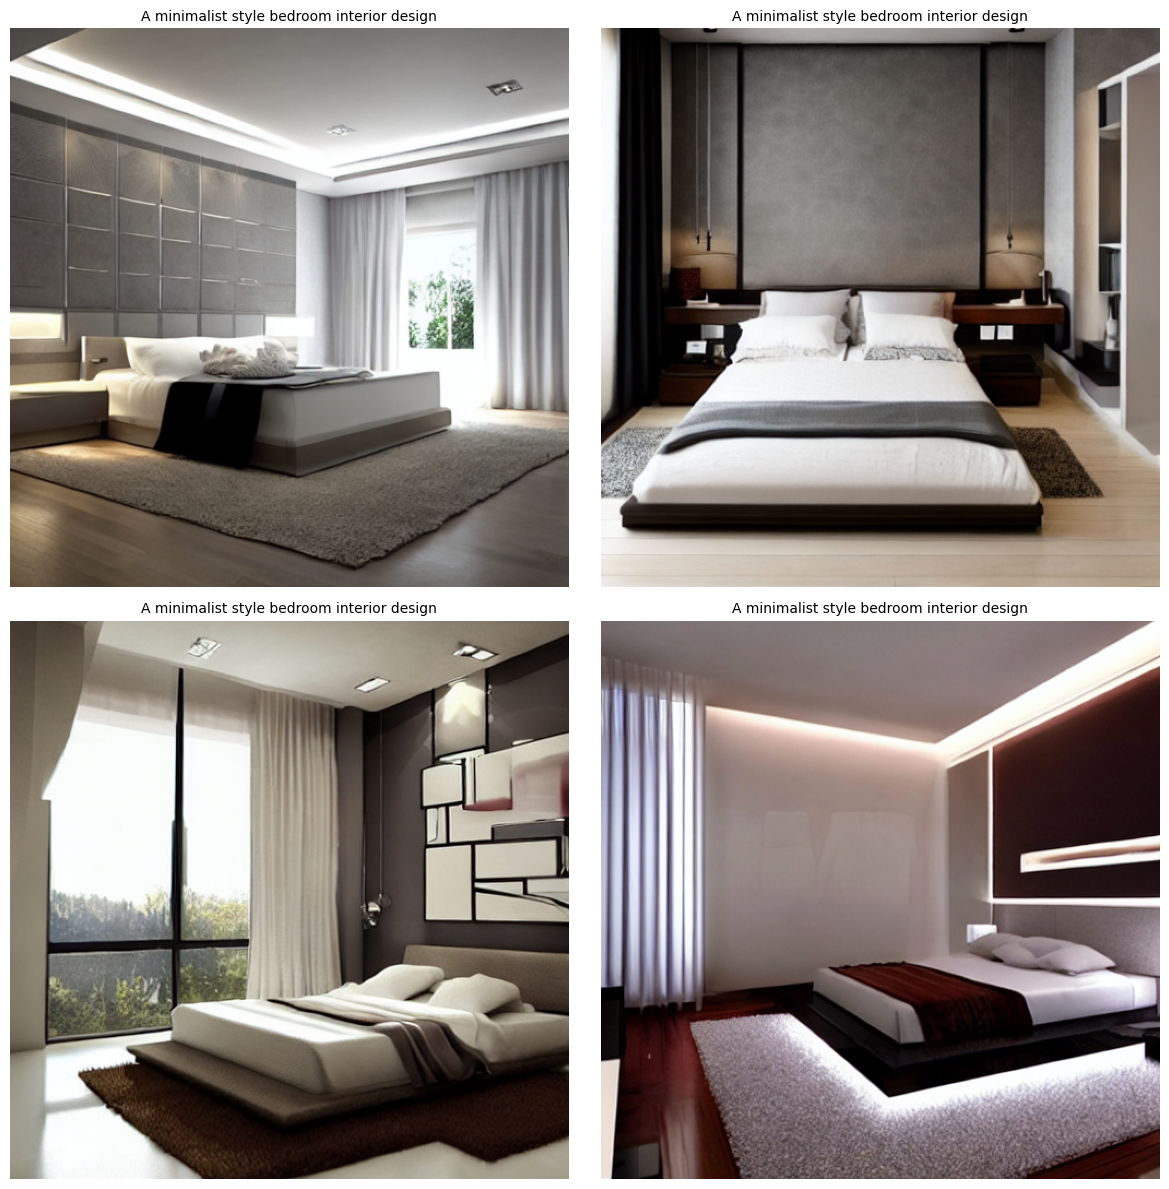


✅ Images saved to /content/output/generated/

Enter your prompt (or 'quit' to exit): A modern style bedroom
🎨 Generating images for: 'A modern style bedroom'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

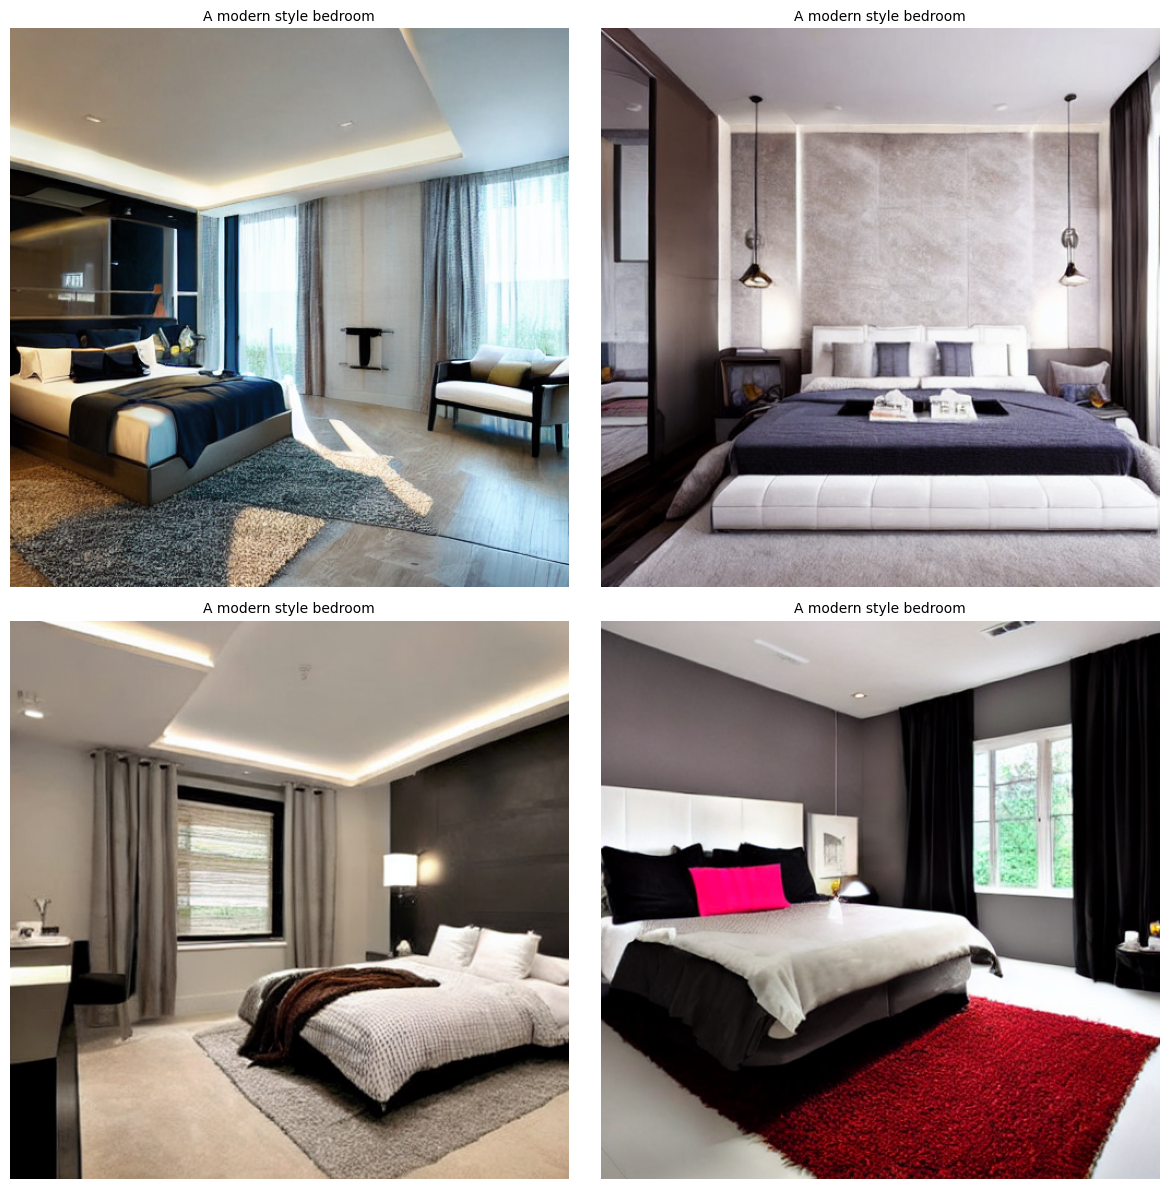


✅ Images saved to /content/output/generated/

Enter your prompt (or 'quit' to exit): modern kitchen
🎨 Generating images for: 'modern kitchen'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

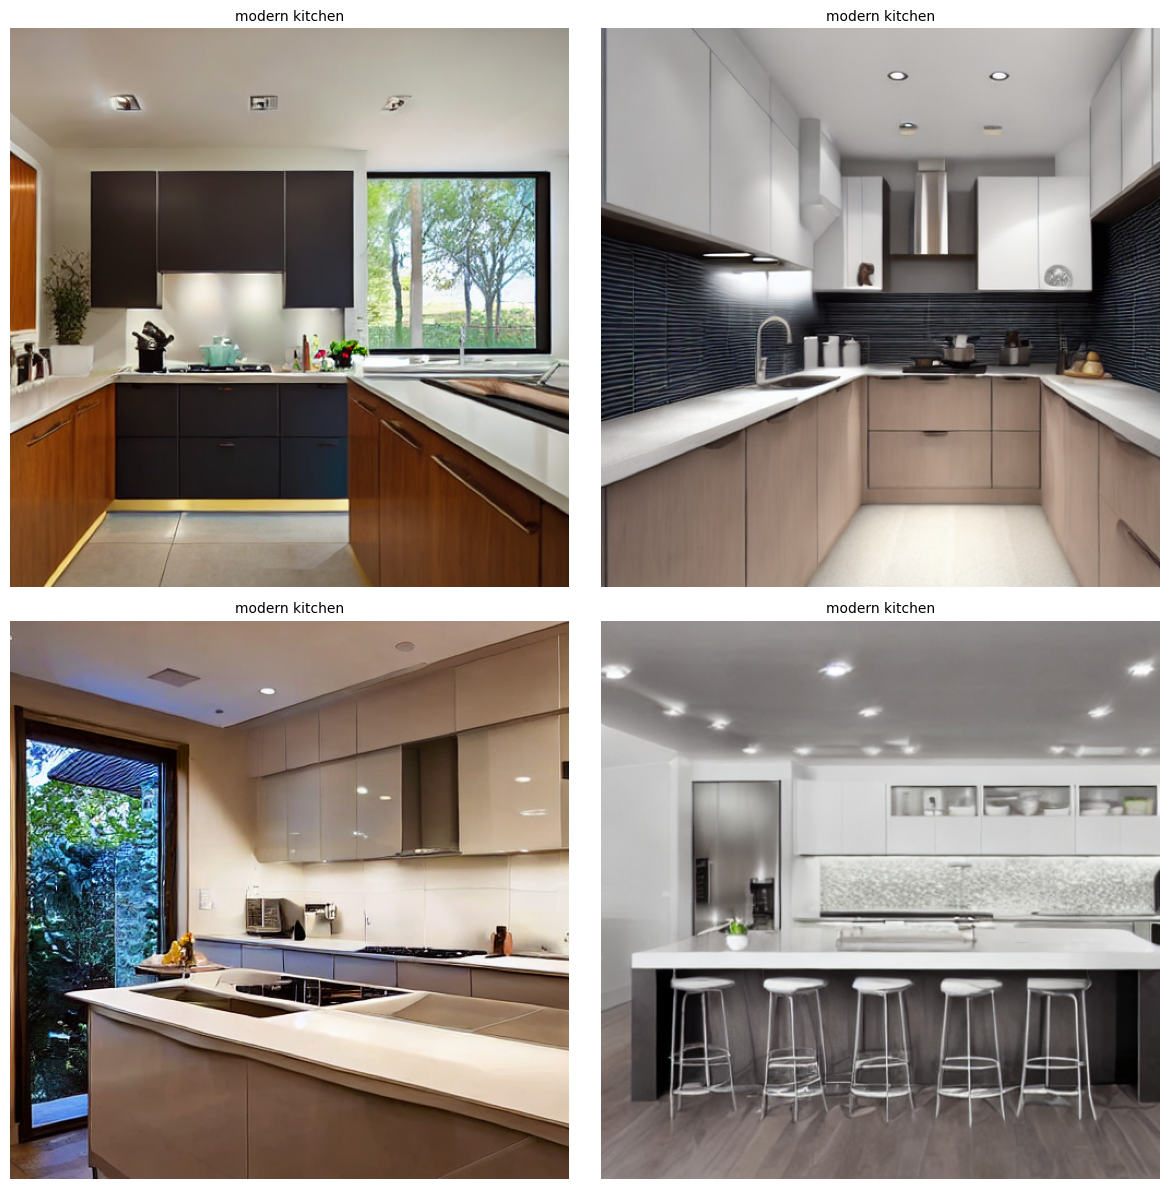


✅ Images saved to /content/output/generated/

Enter your prompt (or 'quit' to exit): quit


In [11]:
# RUN THE CODE
# ============================================================================

if __name__ == "__main__":
    # Uncomment the function you want to run:

    # For full training and generation workflow
    main()

    # For quick test without training
    # quick_test_generation()

    # For evaluation on test set
    # evaluate_on_test_set()